In [1]:
from rlp.envs import MultiArmedBandit, NonStationaryMultiArmedBandit
from rlp.agents import EpsGreedy, EpsGreedyConstStep, UCB, GradientBandit
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

<font size=4>Run this notebook and tune the parameters to test your understandings. Note that timestep starts from 0 in this notebook. 

# 10-Armed Bandit testbed on GreedyMethods

<font size=3> Here we compared the $\epsilon$-Greedy methods on a 10-Armed Bandit, where there are 10 differnt gaussian distributions assigned to 10 arms to generate rewards. And the means of these 10 gaussians are again randomly generated by an another gaussian, the std values are all set as 1. Feel free to tune the settings. 

1000 repeated experiments are run, and 2 statics are compared over different eps. One is the average optimal action rate at timestep $t$, the other one is the average rewards at timestep $t$. Please refer to the textbook if u get confused with these 2 statistics.

In [2]:
def draw(stats):
    """Draw graphs based on experiment stats
    """
    _, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
    ax = ax.ravel()
    for i in range(2):
        for conf in stats:
            ax[i].plot(stats[conf][i], label=conf)

    ax[0].set_ylabel('average reward')
    ax[1].set_ylabel('optimal action rate')
    plt.xlabel('steps')
    plt.tight_layout()
    plt.legend()
    plt.show()

<font size=3> Define a experiment funciton.

In [3]:
#################
# number of arms
################
K = 10


def runEpsGreedy(n_timesteps, eps):
    """ run eps-Greedy method on n-timesteps.
    """
    means = np.random.normal(0, 1, K)              # assign mean rewards for K = 10 arms
    stds = np.ones(K)                               # assign std for K = 10 arms
    initQ = np.zeros(K)                         # assign inital action value estimates Q0, all zero

    bandit = MultiArmedBandit(k=K, means=means, stds=stds)
    agent = EpsGreedy(eps, Q0=initQ)              # build eps-greedy agent
    for _ in range(n_timesteps):
        At = agent.action()                       # agent select action
        Rt = bandit.reward(At)                    # environment gives reward based on agent's action
        agent.get_reward(Rt)                      # agent reveive reward and update status
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

<font size=3> Run the experiment

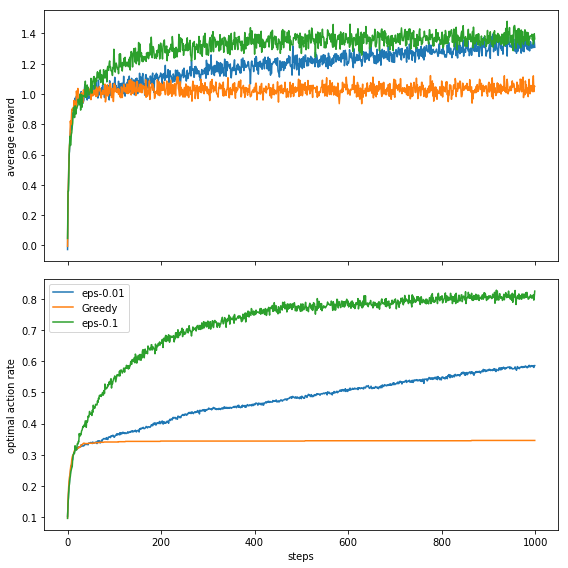

In [4]:
nRuns = 1000                     # repeat 1000 times
nTimeStep = 1000                # how many timesteps would you run
greedyMethodStats = {}

settings = {                    # change the eps if you want
    'Greedy': 0,
    'eps-0.01': 0.01,
    'eps-0.1': 0.1}

for conf, eps in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat experiment', leave=False):
        rewardMat[i], optActRateMat[i]  = runEpsGreedy(nTimeStep, eps)
    greedyMethodStats[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

# show result
draw(greedyMethodStats)

# What's the effect of Const Step size $\alpha$
<font size=3> Here we will tune const step size alpha to see what will happen. Detailed explaination can be found in the textbook.

In [5]:
def tuneAlpha(n_timesteps, alpha):
    """ run eps-Greedy method on n-timesteps.
    """
    means = np.random.normal(0, 1, K)              # assign mean rewards for 10 arms
    stds = np.ones(K)                               # assign std for 10 arms
    initQ = np.zeros(K)                         # assign inital action value estimates Q0, all zero

    bandit = MultiArmedBandit(k=K, means=means, stds=stds)
    agent = EpsGreedyConstStep(eps=0.01, alpha=alpha, Q0=initQ)              # build eps-greedy agent
    for _ in range(n_timesteps):
        At = agent.action()                       # agent select action
        Rt = bandit.reward(At)                    # environment gives reward based on agent's action
        agent.get_reward(Rt)                      # agent reveive reward and update status
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

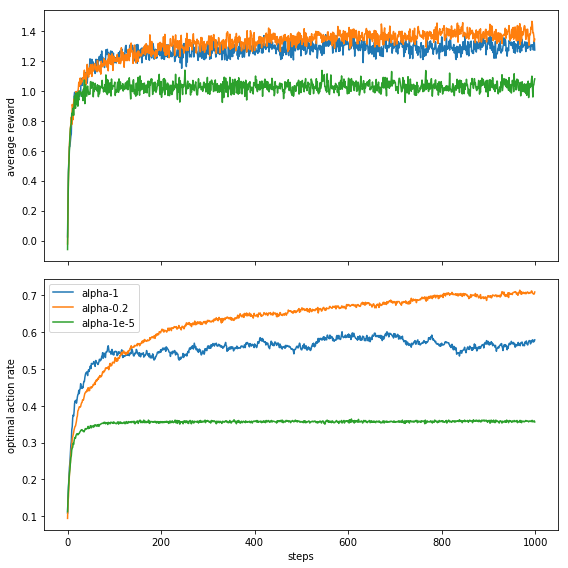

In [6]:
nRuns = 1000
nTimeStep = 1000
tuneAlphaStats = {}

settings = {
    'alpha-1': 1,                # change setting for alpha here
    'alpha-1e-5': 1e-5,
    'alpha-0.2': 0.2}

for conf, alpha in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat experiment', leave=False):
        rewardMat[i], optActRateMat[i]  = tuneAlpha(nTimeStep, alpha)
    tuneAlphaStats[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

# show result
draw(tuneAlphaStats)

# TextBook Exercise 2.5
<font size=3> Compare EpsGreedy action-value methods using average-method or constant step-size under **NonStationary** problems. Here we use `NonStationaryMultiArmedBandit`, which addes a normally distributed increment with mean zero and standard deviation 0.01 to all the mean on its reward distributions on each step.

In [7]:
def runNonStationaryExp(n_timesteps, eps, isConst):
    """ run eps-Greedy method on n-timesteps.
    """
    means = np.random.normal(0, 1, K)              
    stds = np.ones(K)
    initQ = np.zeros(K)    
    
    # Note this MultiArmedBandit is a NonStationary Version..
    bandit = NonStationaryMultiArmedBandit(k=K, means=means, stds=stds)
    agent = EpsGreedyConstStep(eps, Q0=initQ, alpha=0.1) if isConst else EpsGreedy(eps, Q0=initQ)
    for _ in range(n_timesteps):
        At = agent.action()    
        Rt = bandit.reward(At)     
        agent.get_reward(Rt)
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

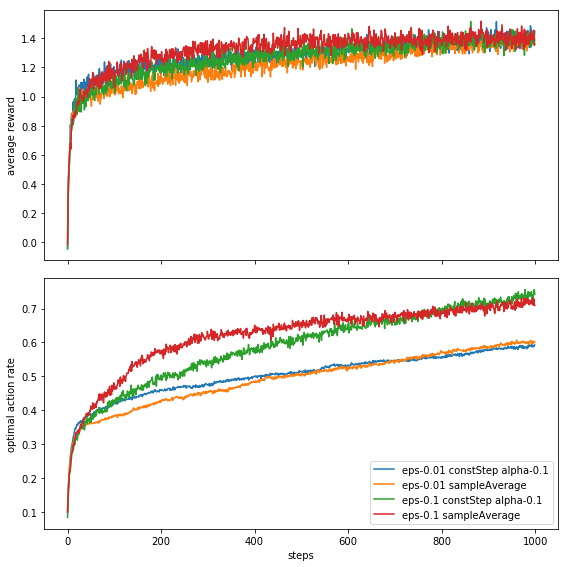

In [8]:
nRuns = 1000
nTimeStep = 1000
nonStationaryStats = {}

settings = {
    'eps-0.1 constStep alpha-0.1': (0.1, True),
    'eps-0.01 constStep alpha-0.1': (0.01, True),
    'eps-0.1 sampleAverage': (0.1, False),
    'eps-0.01 sampleAverage': (0.01, False),
}

for conf, params in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat exps', leave=False):
        rewardMat[i], optActRateMat[i] = runNonStationaryExp(nTimeStep, *params)
    nonStationaryStats[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

draw(nonStationaryStats)

# Optimistic Initial Values
<font size=3> Two differnt settings:
- give an over-optimistic initial estimate for all arms, all set as 5
- give a $0$ estimate for all arms
    
step size $\alpha = 0.1$

In [9]:
def runOptimisticOrRealistic(n_timesteps, eps, isOptimistic):
    means = np.random.normal(0, 1, K)              
    stds = np.ones(K)
    q = 5 if isOptimistic else 0
    initQ = q * np.ones(K)    # assign inital action value estimates Q0 as zero or 5 
    
    bandit = MultiArmedBandit(k=K, means=means, stds=stds)
    # note that now it's a Const StepSize verison of EpsGreedy
    agent = EpsGreedyConstStep(eps, Q0=initQ, alpha=0.1)  # alpha set as 0.1  
    for _ in range(n_timesteps):
        At = agent.action()    
        Rt = bandit.reward(At)     
        agent.get_reward(Rt)
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

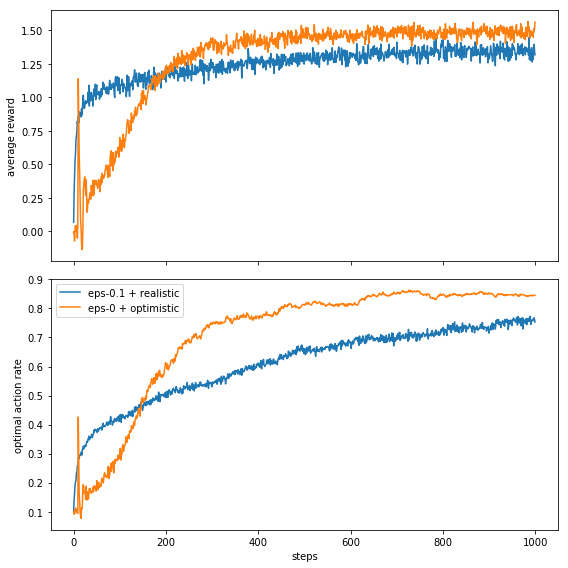

In [10]:
nRuns = 1000
nTimeStep = 1000
OptimisticStats = {}

settings = {
    'eps-0 + optimistic': (0, True),
    'eps-0.1 + realistic': (0.1, False),
}

for conf, params in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat exps', leave=False):
        rewardMat[i], optActRateMat[i] = runOptimisticOrRealistic(nTimeStep, *params)
    OptimisticStats[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

draw(OptimisticStats)

## Upper Confidence Bound (UCB) Action Selection
<font size=3>compare UCB(c = 2) with $\epsilon-$Greedy

In [11]:
def runUCB(n_timesteps, isUCB):
    means = np.random.normal(0, 1, K)              
    stds = np.ones(K)                               
    initQ = np.zeros(K)

    bandit = MultiArmedBandit(k=K, means=means, stds=stds)
    agent = UCB(alpha=0.2, conf_level=2, Q0=initQ) if isUCB else EpsGreedyConstStep(eps=0.1, Q0=initQ, alpha=0.2)
    for _ in range(n_timesteps):
        At = agent.action()    
        Rt = bandit.reward(At)     
        agent.get_reward(Rt)          
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

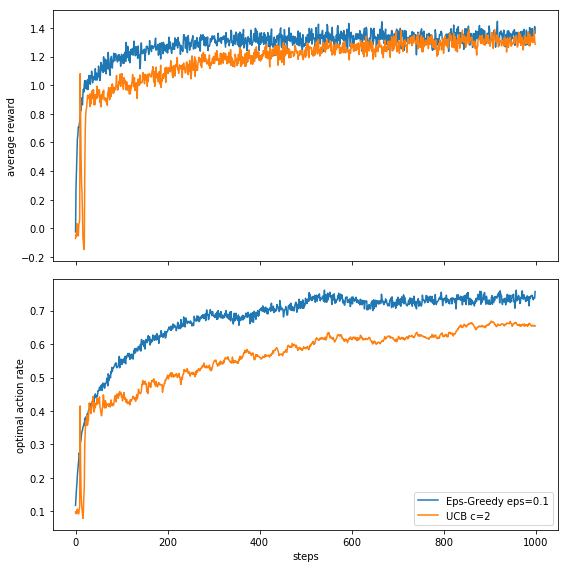

In [12]:
nRuns = 1000
nTimeStep = 1000
UCBStats = {}

settings = {
    'UCB c=2': True,
    'Eps-Greedy eps=0.1': False
}

for conf, isUCB in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat exps', leave=False):
        rewardMat[i], optActRateMat[i] = runUCB(nTimeStep, isUCB)
    UCBStats[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

draw(UCBStats)

# Gradient Bandit Algorithm

In [13]:
def runGB(n_timesteps, alpha, baseline):
    means = np.random.normal(4, 1, K)            #  mean is adjusted
    stds = np.ones(K)
    initH = np.random.randn(K)

    bandit = MultiArmedBandit(k=K, means=means, stds=stds)
    agent = GradientBandit(initH, alpha, baseline)
    for _ in range(n_timesteps):
        At = agent.action()    
        Rt = bandit.reward(At)     
        agent.get_reward(Rt)      
        agent.update()
    
    return np.array(agent.rewards), np.array(agent.actions) == np.argmax(means)

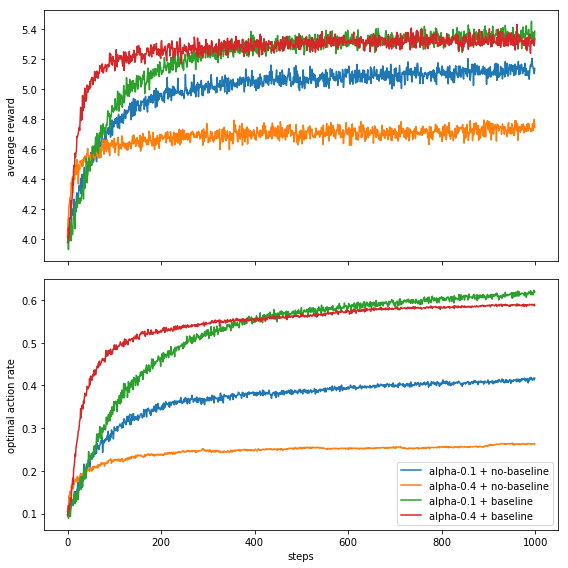

In [14]:
nRuns = 1000
nTimeStep = 1000
gradientMethodStatics = {}
settings = {
    'alpha-0.1 + baseline': (0.1, True),        # setting for alpha and with or without baseline
    'alpha-0.1 + no-baseline': (0.1, False),
    'alpha-0.4 + baseline': (0.4, True),
    'alpha-0.4 + no-baseline': (0.4, False),
}

for conf, params in tqdm_notebook(settings.items(), desc='loop over settings'):
    rewardMat = np.zeros((nRuns, nTimeStep))
    optActRateMat = np.zeros((nRuns, nTimeStep))
    for i in tqdm_notebook(range(nRuns), desc='repeat expriment', leave=False):
        rewardMat[i], optActRateMat[i] = runGB(nTimeStep, *params)
    gradientMethodStatics[conf] = (rewardMat.mean(axis=0), optActRateMat.mean(axis=0))

draw(gradientMethodStatics)